In [139]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [140]:
# Load the dataset
file_path = 'stock_data.csv'  # Replace with the correct file path
stock_data = pd.read_csv(file_path)

# Display the first few rows to understand the structure
print("Dataset preview:")
print(stock_data.head())


Dataset preview:
       Date   Adj Close       Close        High         Low        Open  \
0  1/3/2022  179.076599  182.009995  182.880005  177.710007  177.830002   
1  1/4/2022  176.803833  179.699997  182.940002  179.119995  182.630005   
2  1/5/2022  172.100876  174.919998  180.169998  174.639999  179.610001   
3  1/6/2022  169.227936  172.000000  175.300003  171.639999  172.699997   
4  1/7/2022  169.395218  172.169998  174.139999  171.029999  172.889999   

      Volume Ticker  
0  104487900   AAPL  
1   99310400   AAPL  
2   94537600   AAPL  
3   96904000   AAPL  
4   86709100   AAPL  


In [145]:
print("\nMissing values summary:")
print(stock_data.isnull().sum())



Missing values summary:
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Ticker       0
Return       4
dtype: int64


In [146]:
# Ensure the data is sorted by date and grouped by ticker
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.sort_values(by=['Ticker', 'Date'], inplace=True)

In [147]:
# Calculate daily returns for each ticker
stock_data['Return'] = stock_data.groupby('Ticker')['Adj Close'].pct_change()

In [148]:
# Pivot the data to have tickers as columns and dates as rows for matrix calculations
return_data = stock_data.pivot(index='Date', columns='Ticker', values='Return')

In [149]:
# Drop rows with NaN values (caused by percentage change calculation)
return_data.dropna(inplace=True)

In [150]:
# Calculate mean returns and covariance matrix
mean_returns = return_data.mean().values.reshape(-1, 1)  # Column vector of mean returns
cov_matrix = return_data.cov().values  # Covariance matrix


In [151]:
# Extract list of tickers (assets)
assets = return_data.columns

In [152]:
# Display extracted information
print("\nExtracted Financial Metrics:")
print(f"Assets: {list(assets)}")
print(f"Mean Returns: {mean_returns.flatten()}")
print(f"Covariance Matrix:\n{cov_matrix}")


Extracted Financial Metrics:
Assets: ['AAPL', 'AMZN', 'GOOGL', 'TSLA']
Mean Returns: [ 0.00030223  0.00012949  0.00016673 -0.00023002]
Covariance Matrix:
[[0.00033547 0.00030565 0.00028349 0.000401  ]
 [0.00030565 0.00071928 0.00040142 0.00051552]
 [0.00028349 0.00040142 0.0004828  0.00039277]
 [0.000401   0.00051552 0.00039277 0.00143682]]


In [153]:
mean_returns = np.array([[0.00030223], [0.00012949], [0.00016673], [-0.00023002]])
cov_matrix = np.array([
    [0.00033547, 0.00030565, 0.00028349, 0.000401],
    [0.00030565, 0.00071928, 0.00040142, 0.00051552],
    [0.00028349, 0.00040142, 0.0004828, 0.00039277],
    [0.000401, 0.00051552, 0.00039277, 0.00143682]
])

In [154]:
num_assets = len(assets)

In [155]:
# Define optimization variables
w = cp.Variable(num_assets)  # Portfolio weights
gamma = cp.Parameter(nonneg=True)  # Risk aversion parameter

In [156]:
# Define objective function: Maximize μᵀw - γwᵀΣw
portfolio_return = mean_returns.T @ w
portfolio_risk = cp.quad_form(w, cov_matrix)
objective = cp.Maximize(portfolio_return - gamma * portfolio_risk)

In [157]:
# Define constraints
constraints = [
    cp.sum(w) == 1,  # Weights sum to 1
    w >= 0           # Long-only portfolio
]

In [158]:
# Define the problem
problem = cp.Problem(objective, constraints)

In [159]:
# Solve for varying gamma to observe trade-off
gamma_values = np.logspace(-2, 3, 50)  # Range of gamma values
risk_data = []
return_data = []

In [160]:
for g in gamma_values:
    gamma.value = g
    problem.solve()
    risk_data.append(np.sqrt(portfolio_risk.value))  # Standard deviation (risk)
    return_data.append(portfolio_return.value)      # Mean return

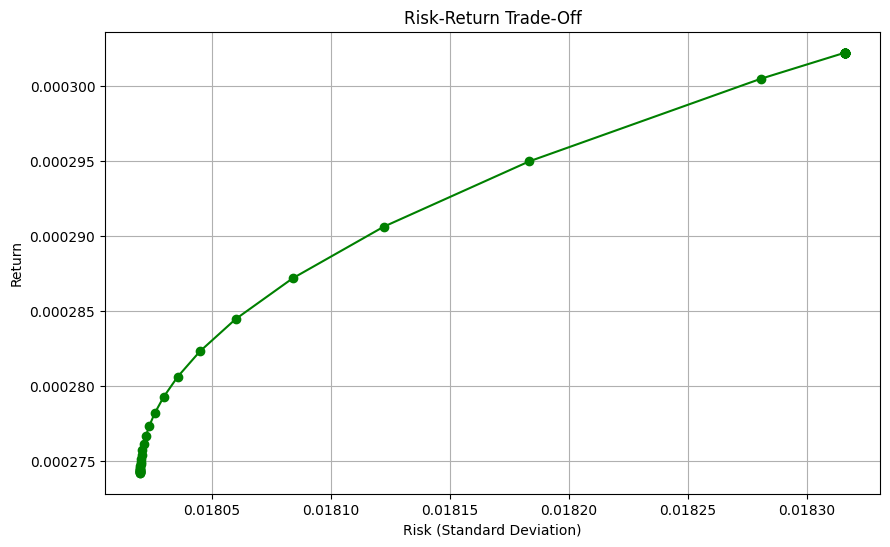

In [161]:
# Plot the risk-return trade-off
plt.figure(figsize=(10, 6))
plt.plot(risk_data, return_data, marker='o', color='green')
plt.title('Risk-Return Trade-Off')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.grid()
plt.show()

In [162]:
# Post-process weights to eliminate near-zero values
def clean_weights(weights, threshold=1e-6):
    return {asset: (w if abs(w) > threshold else 0.0) for asset, w in weights.items()}

# Display results for specific gamma values with cleaned weights
print("\nSample Optimal Portfolios (Cleaned):")
for g in [gamma_values[0], gamma_values[len(gamma_values)//2], gamma_values[-1]]:
    gamma.value = g
    problem.solve()
    raw_weights = dict(zip(assets, w.value))
    cleaned_weights = clean_weights(raw_weights)
    print(f"\nFor γ = {g:.2f}:")
    print(f"Optimal Weights: {cleaned_weights}")
    print(f"Expected Return: {portfolio_return.value.item():.6f}")
    print(f"Portfolio Risk: {np.sqrt(portfolio_risk.value):.6f}")



Sample Optimal Portfolios (Cleaned):

For γ = 0.01:
Optimal Weights: {'AAPL': 1.0, 'AMZN': 0.0, 'GOOGL': 0.0, 'TSLA': 0.0}
Expected Return: 0.000302
Portfolio Risk: 0.018316

For γ = 3.56:
Optimal Weights: {'AAPL': 0.8689551232789824, 'AMZN': 0.0, 'GOOGL': 0.13104487672101758, 'TSLA': 0.0}
Expected Return: 0.000284
Portfolio Risk: 0.018060

For γ = 1000.00:
Optimal Weights: {'AAPL': 0.7934169684428348, 'AMZN': 0.0, 'GOOGL': 0.2065830315571652, 'TSLA': 0.0}
Expected Return: 0.000274
Portfolio Risk: 0.018020


# Checking convexity

In [82]:
# Step 1: Check if covariance matrix is PSD
eigenvalues = np.linalg.eigvals(cov_matrix)
is_psd = np.all(eigenvalues >= 0)


In [99]:
print("Covariance Matrix:")
print(cov_matrix)
print("\nEigenvalues of Covariance Matrix:")
print(eigenvalues)
print(f"\nIs the covariance matrix positive semi-definite (PSD)? {is_psd}")

Covariance Matrix:
[[0.00033547 0.00030565 0.00028349 0.000401  ]
 [0.00030565 0.00071928 0.00040142 0.00051552]
 [0.00028349 0.00040142 0.0004828  0.00039277]
 [0.000401   0.00051552 0.00039277 0.00143682]]

Eigenvalues of Covariance Matrix:
[0.0020935  0.00056808 0.00010856 0.00020423]

Is the covariance matrix positive semi-definite (PSD)? True


In [98]:
# Step 2: Mathematical Justification (Output Explanation)
print("\nMathematical Justification of Convexity:")
print("1. Objective Function:")
print("   - μᵀw is linear and convex.")
print("   - wᵀΣw is convex because Σ is PSD (as shown above).")
print("   - The weighted sum μᵀw - γwᵀΣw is convex for γ ≥ 0.")
print("\n2. Constraints:")
print("   - ∑w = 1 is affine and hence convex.")
print("   - w ≥ 0 defines a convex set (non-negativity constraint).")


Mathematical Justification of Convexity:
1. Objective Function:
   - μᵀw is linear and convex.
   - wᵀΣw is convex because Σ is PSD (as shown above).
   - The weighted sum μᵀw - γwᵀΣw is convex for γ ≥ 0.

2. Constraints:
   - ∑w = 1 is affine and hence convex.
   - w ≥ 0 defines a convex set (non-negativity constraint).


# Add non-convexity

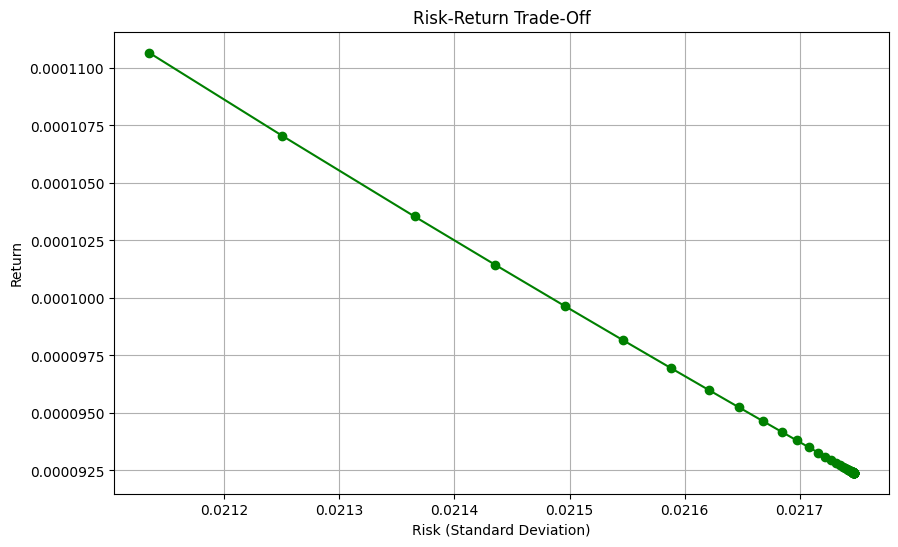

In [163]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
n = len(mean_returns)  # Number of assets
w = cp.Variable(n)     # Portfolio weights
gamma = cp.Parameter(nonneg=True)  # Risk aversion parameter

# Define portfolio return and risk
portfolio_return = mean_returns.T @ w
portfolio_risk = cp.quad_form(w, cov_matrix)

# Add the non-convex penalty
concentration_penalty = cp.sum_squares(w) / n  # Normalize penalty
objective = cp.Maximize(portfolio_return - gamma * portfolio_risk - gamma * concentration_penalty)

# Constraints
constraints = [
    cp.sum(w) == 1,   # Weights sum to 1
    w >= 0,           # Long-only portfolio
    w[0] + w[1] <= 0.5  # Example non-linear constraint
]

# Solve for varying gamma
gamma_values = np.logspace(-2, 3, 50)
risk_data = []
return_data = []

for g in gamma_values:
    gamma.value = g  # Update gamma value
    problem = cp.Problem(objective, constraints)  # Redefine the problem
    problem.solve(solver=cp.SCS)  # Use a solver that supports non-convex problems

    if problem.status in ["optimal", "optimal_inaccurate"]:
        risk_data.append(np.sqrt(portfolio_risk.value))
        return_data.append(portfolio_return.value)
    else:
        print(f"Solver failed for gamma = {g}")

# Plot the risk-return trade-off
plt.figure(figsize=(10, 6))
plt.plot(risk_data, return_data, marker='o', color='green')
plt.title('Risk-Return Trade-Off')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.grid(True)
plt.show()


In [164]:
# Display results for specific gamma values with cleaned weights
print("\nSample Optimal Portfolios (Cleaned):")
for g in [gamma_values[0], gamma_values[len(gamma_values)//2], gamma_values[-1]]:
    gamma.value = g
    problem = cp.Problem(objective, constraints)  # Redefine the problem
    problem.solve(solver=cp.SCS)  # Solve for specific gamma value

    if problem.status in ["optimal", "optimal_inaccurate"]:
        raw_weights = dict(zip(assets, w.value))  # Convert to dictionary with asset names
        cleaned_weights = clean_weights(raw_weights)
        print(f"\nFor γ = {g:.2f}:")
        print(f"Optimal Weights: {cleaned_weights}")
        print(f"Expected Return: {portfolio_return.value.item():.6f}")
        print(f"Portfolio Risk: {np.sqrt(portfolio_risk.value):.6f}")
    else:
        print(f"Solver failed for γ = {g:.2f}")


Sample Optimal Portfolios (Cleaned):

For γ = 0.01:
Optimal Weights: {'AAPL': 0.2671772138284121, 'AMZN': 0.23282273666756068, 'GOOGL': 0.28929048549012476, 'TSLA': 0.21070956405529537}
Expected Return: 0.000111
Portfolio Risk: 0.021135

For γ = 3.56:
Optimal Weights: {'AAPL': 0.2503572261710664, 'AMZN': 0.2496444472633348, 'GOOGL': 0.2507019418221704, 'TSLA': 0.24929638356038278}
Expected Return: 0.000092
Portfolio Risk: 0.021745

For γ = 1000.00:
Optimal Weights: {'AAPL': 0.25031432498245954, 'AMZN': 0.24969825405814033, 'GOOGL': 0.25058557149491684, 'TSLA': 0.24940184680835537}
Expected Return: 0.000092
Portfolio Risk: 0.021747


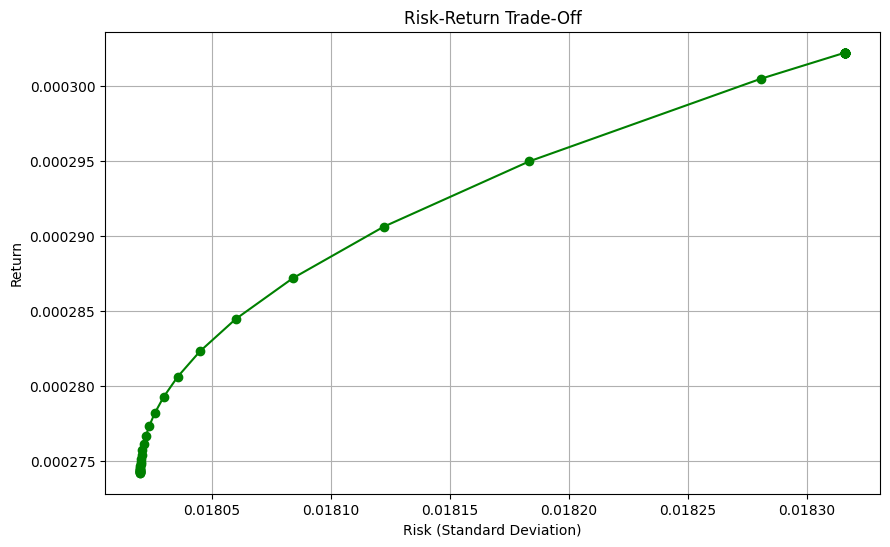


Sample Optimal Portfolios (Cleaned):

For γ = 0.01:
Optimal Weights: {'AAPL': 1.0, 'AMZN': 0.0, 'GOOGL': 0.0, 'TSLA': 0.0}
Expected Return: 0.000302
Portfolio Risk: 0.018316

For γ = 3.56:
Optimal Weights: {'AAPL': 0.8689551232789824, 'AMZN': 0.0, 'GOOGL': 0.13104487672101758, 'TSLA': 0.0}
Expected Return: 0.000284
Portfolio Risk: 0.018060

For γ = 1000.00:
Optimal Weights: {'AAPL': 0.7934169684428348, 'AMZN': 0.0, 'GOOGL': 0.2065830315571652, 'TSLA': 0.0}
Expected Return: 0.000274
Portfolio Risk: 0.018020


In [165]:

# Define the portfolio return and risk
portfolio_return = mean_returns.T @ w
portfolio_risk = cp.quad_form(w, cov_matrix)

# Simplified (convex) objective: Maximize return with risk aversion (no non-linear components)
gamma = cp.Parameter(nonneg=True)
objective = cp.Maximize(portfolio_return - gamma * portfolio_risk)

# Constraints (simple convex constraints)
constraints = [
    cp.sum(w) == 1,  # Weights sum to 1
    w >= 0           # Long-only portfolio (no short-selling)
]

# Create a problem
problem = cp.Problem(objective, constraints)

# Solve for varying gamma to observe trade-off
gamma_values = np.logspace(-2, 3, 50)  # Range of gamma values
risk_data = []
return_data = []

# Loop through the gamma values and solve the optimization problem
for g in gamma_values:
    gamma.value = g
    problem.solve()
    risk_data.append(np.sqrt(portfolio_risk.value))  # Standard deviation (risk)
    return_data.append(portfolio_return.value)      # Mean return

# Plot the risk-return trade-off
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(risk_data, return_data, marker='o', color='green')
plt.title('Risk-Return Trade-Off')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.grid(True)
plt.show()

def clean_weights(weights, threshold=1e-6):
    """Set weights below threshold to zero."""
    return {asset: (w if abs(w) > threshold else 0.0) for asset, w in weights.items()}

# Display results for specific gamma values with cleaned weights
print("\nSample Optimal Portfolios (Cleaned):")
for g in [gamma_values[0], gamma_values[len(gamma_values)//2], gamma_values[-1]]:
    gamma.value = g
    problem.solve()
    raw_weights = dict(zip(assets, w.value))  # Convert weights to a dictionary with asset names
    cleaned_weights = clean_weights(raw_weights)  # Clean the weights
    print(f"\nFor γ = {g:.2f}:")
    print(f"Optimal Weights: {cleaned_weights}")
    print(f"Expected Return: {portfolio_return.value.item():.6f}")
    print(f"Portfolio Risk: {np.sqrt(portfolio_risk.value):.6f}")

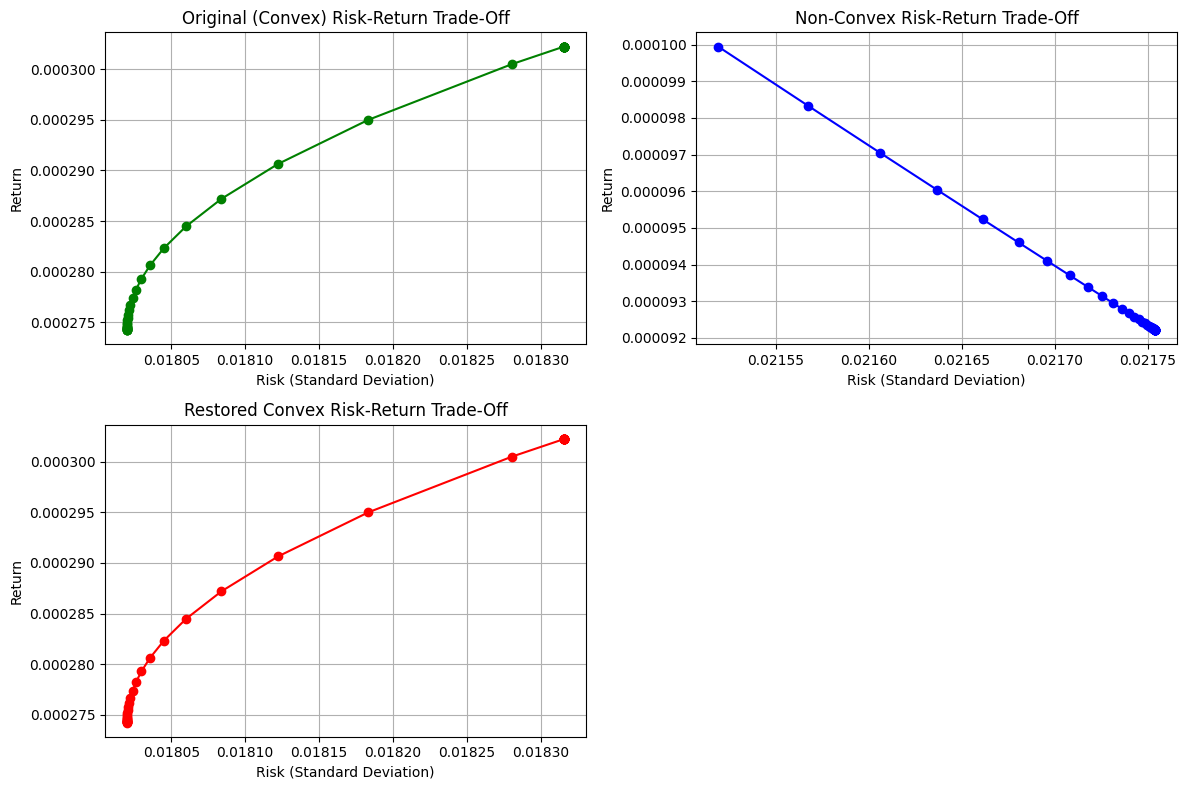


Sample Optimal Portfolios (Convex):

Model: convex, γ = 0.01:
Optimal Weights: {'AAPL': 1.0, 'AMZN': 0.0, 'GOOGL': 0.0, 'TSLA': 0.0}
Expected Return: 0.000302
Portfolio Risk: 0.018316

Model: convex, γ = 3.56:
Optimal Weights: {'AAPL': 0.8689551232789823, 'AMZN': 0.0, 'GOOGL': 0.13104487672101775, 'TSLA': 0.0}
Expected Return: 0.000284
Portfolio Risk: 0.018060

Model: convex, γ = 1000.00:
Optimal Weights: {'AAPL': 0.7934169684428354, 'AMZN': 0.0, 'GOOGL': 0.2065830315571646, 'TSLA': 0.0}
Expected Return: 0.000274
Portfolio Risk: 0.018020

Sample Optimal Portfolios (Non-Convex):

Model: non-convex, γ = 0.01:
Optimal Weights: {'AAPL': 1.0, 'AMZN': 0.0, 'GOOGL': 0.0, 'TSLA': 0.0}
Expected Return: 0.000302
Portfolio Risk: 0.018316

Model: non-convex, γ = 3.56:
Optimal Weights: {'AAPL': 0.8689551232789821, 'AMZN': 0.0, 'GOOGL': 0.13104487672101797, 'TSLA': 0.0}
Expected Return: 0.000284
Portfolio Risk: 0.018060

Model: non-convex, γ = 1000.00:
Optimal Weights: {'AAPL': 0.7934169684428353, 

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Assuming the data (mean_returns, cov_matrix, assets) are already defined

# Function to clean the weights
def clean_weights(weights, threshold=1e-6):
    return {asset: (w if abs(w) > threshold else 0.0) for asset, w in weights.items()}

# Function to solve and calculate risk-return trade-off for different models
def solve_portfolio(model_type, gamma_values):
    n = len(mean_returns)  # Number of assets
    w = cp.Variable(n)  # Portfolio weights
    gamma = cp.Parameter(nonneg=True)

    # Define objective function based on model type
    if model_type == 'convex':
        portfolio_return = mean_returns.T @ w
        portfolio_risk = cp.quad_form(w, cov_matrix)
        objective = cp.Maximize(portfolio_return - gamma * portfolio_risk)  # Convex objective
    elif model_type == 'non-convex':
        portfolio_return = mean_returns.T @ w
        portfolio_risk = cp.quad_form(w, cov_matrix)
        concentration_penalty = cp.sum_squares(w)  # Non-convex term
        objective = cp.Maximize(portfolio_return - gamma * portfolio_risk - gamma * concentration_penalty)

    else:  # 'restored-convex'
        portfolio_return = mean_returns.T @ w
        portfolio_risk = cp.quad_form(w, cov_matrix)
        objective = cp.Maximize(portfolio_return - gamma * portfolio_risk)  # Restored convex

    # Constraints (simple convex constraints)
    constraints = [
        cp.sum(w) == 1,  # Weights sum to 1
        w >= 0           # Long-only portfolio (no short-selling)
    ]

    # Create a problem and solve it
    problem = cp.Problem(objective, constraints)

    # Solve for varying gamma to observe trade-off
    risk_data = []
    return_data = []

    for g in gamma_values:
        gamma.value = g
        problem.solve()
        risk_data.append(np.sqrt(portfolio_risk.value))  # Standard deviation (risk)
        return_data.append(portfolio_return.value)      # Mean return

    return risk_data, return_data

# Gamma values to observe the trade-off
gamma_values = np.logspace(-2, 3, 50)

# Solve for each case (Convex, Non-Convex, Restored Convex)
risk_data_convex, return_data_convex = solve_portfolio('convex', gamma_values)
risk_data_nonconvex, return_data_nonconvex = solve_portfolio('non-convex', gamma_values)
risk_data_restored, return_data_restored = solve_portfolio('restored-convex', gamma_values)

# Plot the risk-return trade-offs for each case
plt.figure(figsize=(12, 8))

# Convex
plt.subplot(2, 2, 1)
plt.plot(risk_data_convex, return_data_convex, marker='o', color='green')
plt.title('Original (Convex) Risk-Return Trade-Off')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.grid(True)

# Non-Convex
plt.subplot(2, 2, 2)
plt.plot(risk_data_nonconvex, return_data_nonconvex, marker='o', color='blue')
plt.title('Non-Convex Risk-Return Trade-Off')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.grid(True)

# Restored Convex
plt.subplot(2, 2, 3)
plt.plot(risk_data_restored, return_data_restored, marker='o', color='red')
plt.title('Restored Convex Risk-Return Trade-Off')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Optional: Display sample portfolios for each case
def display_sample_portfolios(model_type, gamma_values):
    for g in [gamma_values[0], gamma_values[len(gamma_values)//2], gamma_values[-1]]:
        gamma.value = g
        problem.solve()
        raw_weights = dict(zip(assets, w.value))  # Convert weights to a dictionary with asset names
        cleaned_weights = clean_weights(raw_weights)  # Clean the weights
        print(f"\nModel: {model_type}, γ = {g:.2f}:")
        print(f"Optimal Weights: {cleaned_weights}")
        print(f"Expected Return: {portfolio_return.value.item():.6f}")
        print(f"Portfolio Risk: {np.sqrt(portfolio_risk.value):.6f}")

# Display sample portfolios for each case
print("\nSample Optimal Portfolios (Convex):")
display_sample_portfolios('convex', gamma_values)
print("\nSample Optimal Portfolios (Non-Convex):")
display_sample_portfolios('non-convex', gamma_values)
print("\nSample Optimal Portfolios (Restored Convex):")
display_sample_portfolios('restored-convex', gamma_values)
